In [1]:
#import packages
import ast
import swifter
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
import pandas as pd

In [ ]:
#notes:
#Blame and praise
# entailsments
#does not entail an actually entailment

#Blame vs endorsement
#Also report initial inspection of model wher praise and neutral was added to the hypothesis paramenter instead of blame/not blame.
# something about hieracivcal order and the words not being complete opisats and therefore the relative probabilities entails needed information
# in addition to the absolute probability

In [2]:
#define functions


def extract_blame_from_paragraph_lookup(input_str):
    """
    Returns a binary list for blame per sentence:
    1 if blame is highest among labels and >= 0.8, else 0
    Handles arbitrary label order.
    """
    try:
        
        sentence_list = ast.literal_eval(input_str)
    except Exception:
        return []

    # List comprehension is faster than appending in a loop
    blame_binary = [
        int(
            (label_score := {label: score for label, score in zip(sent['labels'], sent['scores'])})['blame']
            >= max(label_score.get('praise', 0.0), label_score.get('neutral', 0.0), 0.8)
        )
        for sent in sentence_list
    ]


    return blame_binary

#example usage: final_data['blame_binary'] = final_data['blame_in_text'].swifter.apply(extract_blame_from_paragraph_lookup)


#get row indices (paragraphs) that contain blame
def get_rows_with_blame(df, col="blame_binary"):
    """
    Returns row indices where the list in `col` contains at least one 1.
    Handles both real lists and stringified lists.
    """
    indices = []
    for i, values in zip(df.index, df[col]):
        if isinstance(values, str):  # convert only if it's a string
            values = ast.literal_eval(values)
        if 1 in values:
            indices.append(i)
    return indices

#example usage: row_indices = get_rows_with_blame(final_data, col="blame_binary")
#print(row_indices[:10])


#get paragraphs and sentence indices of blame True
def get_rows_and_positions(df, col="blame_binary"):
    """
    Returns {row_index: [positions_of_1s]}.
    Handles both real lists and stringified lists.
    """
    results = {}
    for i, values in zip(df.index, df[col]):
        if isinstance(values, str):
            values = ast.literal_eval(values)
        ones = [j for j, v in enumerate(values) if v == 1]
        if ones:
            results[i] = ones
    return results

#example usage: rows_with_positions = get_rows_and_positions(final_data, col="blame_binary")
#print(rows_with_positions)

#
#get danish sentences containing blame from indices extracted as above

def danish_sentences_with_blame_extraction(dict, data, text_column):


    rows = list(dict.keys())
    sentences = {}

    for para in rows:
        sentence_indices = dict[para]
        text_sentences = ast.literal_eval(data.loc[para][text_column])
        
        blame_sentence_dict = {}
        for indx in sentence_indices:
            blame_sentence = text_sentences[indx]
            blame_sentence_dict[indx] = blame_sentence
        
        
        sentences[para] = blame_sentence_dict

    return sentences


#example usage: danish_sentences_with_blame = danish_sentences_with_blame_extraction(rows_with_positions, final_data, 'da_segmented_text')


#extract blame percentage:

import ast

def total_blame_percentage(string_rows):
    """
    Calculate the total percentage of blame-sentences across all rows,
    converting string representations of lists into actual lists.
    
    Parameters
    ----------
    string_rows : list of str
        Each element is a string like '[1, 0, 1]' representing a row of blame labels.

    Returns
    -------
    float
        Total percentage of blame-sentences (0–100).
    """
    total_sentences = 0
    total_blame = 0

    for row_str in string_rows:
        try:
            row = row_str  # convert string to list
            #row = ast.literal_eval(row_str)
            if not isinstance(row, list):
                continue  # skip if not a list
            row = [int(val) for val in row]  # ensure integers
            total_sentences += len(row)
            total_blame += sum(row)
        except (ValueError, SyntaxError):
            continue  # skip invalid rows

    if total_sentences == 0:
        return 0.0

    return (total_blame / total_sentences) * 100, total_sentences, total_blame

#Example usage: percentage_blame, total_sent, total_blame= total_blame_percentage(final_data['blame_binary'])

#extract blame scores

def get_blame_scores(data, blame_in_text_column = 'blame_in_text'):
    all_blame_scores = []

    for i in range(len(data)):
        dict_labels = ast.literal_eval(data.loc[i][blame_in_text_column])

        blame_list = [(label_score := {label: score for label, score in zip(sent['labels'], sent['scores'])})['blame'] for sent in dict_labels]

        all_blame_scores +=blame_list
    return all_blame_scores


#make vizualization of the distribution

def vizualize_blame_prob(blame_scores):
    len_blame_scores = len(blame_scores)
    fig, axs = plt.subplots(len_blame_scores, 2, figsize=(12, 10))
    for i in range(len_blame_scores):
        axs[i,0].hist(blame_scores[i], log = True, bins = 50)
        axs[0, 0].set_title('Log transformed y axis')
        axs[i,1].hist(blame_scores[i], bins = 50)
        axs[0, 1].set_title('absolute y-axis')

    fig.suptitle('Distribution of blame probabilities by template (log transformed counts/absolute counts)')

    for ax in axs.flat:
        ax.set(xlabel='probability', ylabel='count')
    fig.show()


In [3]:
#Data with all templates


all_templates_data = pd.read_csv("/work/MarkusLundsfrydJensen#1865/Bachelor_project/annotation_data_fifth_template_appended.csv")

all_templates_data.head()

,Unnamed: 0,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,parliament,iso3country,da_segmented_text,translated_text,blame_in_text,second_template_blame_in_text,third_template_blame_in_text,fourth_template_blame_in_text,fifth_template_blame_in_text
0,0,1997-10-07,Dagsorden,1,Gert Petersen,NaN,NaN,True,191,Mødet er åbnet. I henhold til grundloven er Fo...,DK-Folketing,DNK,"['Mødet er åbnet.', 'I henhold til grundloven ...","['The meeting is open.', 'Under the Constituti...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'..."
1,1,1997-10-07,Dagsorden,2,Formanden,NaN,NaN,True,182,"Jeg vil gerne takke Tinget for den tillid, man...",DK-Folketing,DNK,"['Jeg vil gerne takke Tinget for den tillid, m...",['I would like to thank Things for the confide...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...
2,2,1997-10-07,Statsministerens redegørelse i henhold til gru...,3,Poul Nyrup Rasmussen,S,379.0,False,18662,For 25 år siden sagde et flertal i befolkninge...,DK-Folketing,DNK,['For 25 år siden sagde et flertal i befolknin...,"['Twenty-five years ago, a majority of the peo...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori..."
3,3,1997-10-09,1) Indstilling fra Udvalget til Valgs Prøvelse.,2,Formanden,NaN,NaN,True,47,Fra Udvalget til Valgs Prøvelse har jeg modtag...,DK-Folketing,DNK,"['Fra Udvalget til Valgs', 'Prøvelse', 'har je...",['From the Committee to the Committee of the R...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...
4,4,1997-10-09,2) Forhandling om redegørelse nr. R 1.,3,Torben Lund,S,379.0,False,2865,Vi står over for en meget afgørende folketings...,DK-Folketing,DNK,['Vi står over for en meget afgørende folketin...,['We are faced with a very crucial parliamenta...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...


In [4]:
blame_columns = ["blame_in_text","second_template_blame_in_text","third_template_blame_in_text","fourth_template_blame_in_text","fifth_template_blame_in_text"]


In [5]:
#Sanity checks:
#check if translated, orignal and blame probabilty are same lengt (extend for all templates)

for column in blame_columns:
    for indx in range(len(all_templates_data)):

        temo = all_templates_data.loc[indx]

        l_da = len(ast.literal_eval(temo['da_segmented_text']))
        l_en = len(ast.literal_eval(temo['translated_text']))
        l_bl = len(ast.literal_eval(temo[column]))

        if l_da != l_en != l_bl:
            print(column)
            print(temo)

In [5]:
import ipywidgets
# apply extract blame from paragraph lookup function in order to evaulate blame from PolDebate probabilities

for i, column in enumerate(blame_columns):
    all_templates_data[f'blame_binary_temp_{i+1}'] = all_templates_data[column].swifter.apply(extract_blame_from_paragraph_lookup)

all_templates_data.head()

Pandas Apply:   0%|          | 0/36314 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/36314 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/36314 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/36314 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/36314 [00:00<?, ?it/s]

,Unnamed: 0,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,...,blame_in_text,second_template_blame_in_text,third_template_blame_in_text,fourth_template_blame_in_text,fifth_template_blame_in_text,blame_binary_temp_1,blame_binary_temp_2,blame_binary_temp_3,blame_binary_temp_4,blame_binary_temp_5
0,0,1997-10-07,Dagsorden,1,Gert Petersen,NaN,NaN,True,191,Mødet er åbnet. I henhold til grundloven er Fo...,...,"[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,1997-10-07,Dagsorden,2,Formanden,NaN,NaN,True,182,"Jeg vil gerne takke Tinget for den tillid, man...",...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
2,2,1997-10-07,Statsministerens redegørelse i henhold til gru...,3,Poul Nyrup Rasmussen,S,379.0,False,18662,For 25 år siden sagde et flertal i befolkninge...,...,"[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,1997-10-09,1) Indstilling fra Udvalget til Valgs Prøvelse.,2,Formanden,NaN,NaN,True,47,Fra Udvalget til Valgs Prøvelse har jeg modtag...,...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
4,4,1997-10-09,2) Forhandling om redegørelse nr. R 1.,3,Torben Lund,S,379.0,False,2865,Vi står over for en meget afgørende folketings...,...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
#Do vizualization of blame probability distribution for all templates
#alter function to make it subplots

all_blame_scores = []

for column in blame_columns:
    all_blame_scores.append(get_blame_scores(all_templates_data, blame_in_text_column = column))

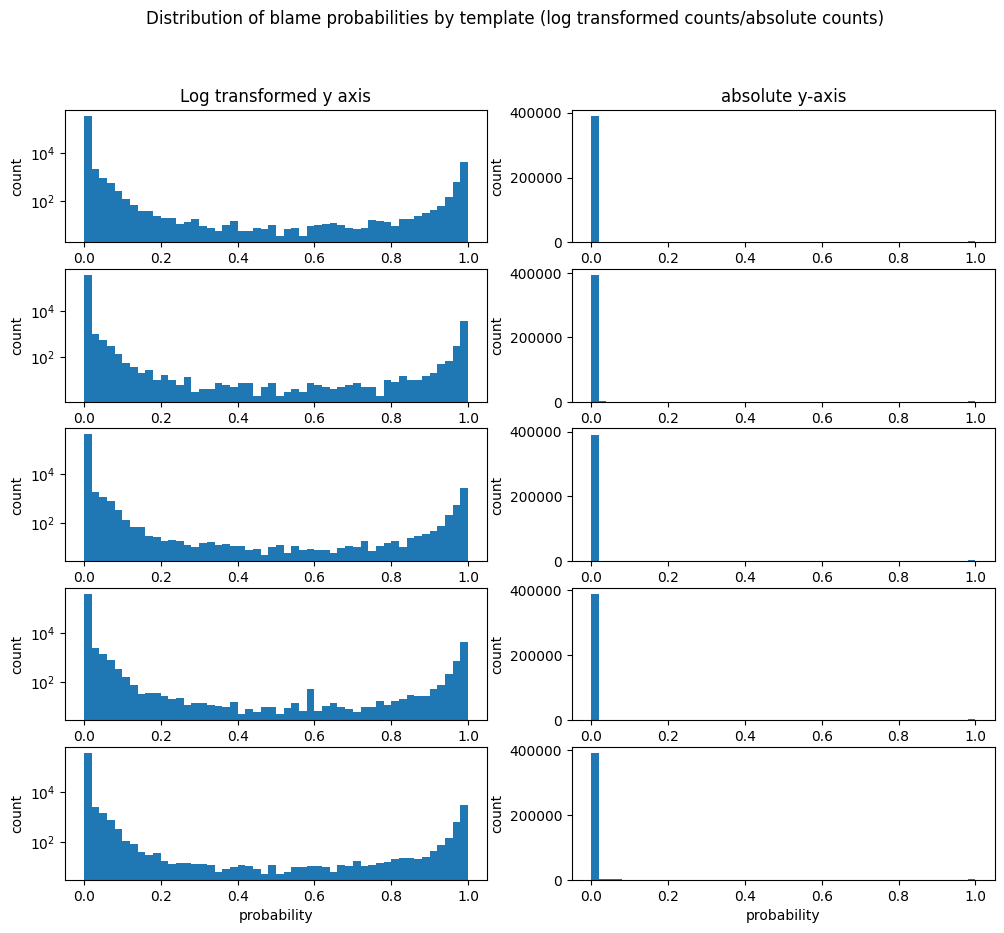

In [7]:
vizualize_blame_prob(all_blame_scores)

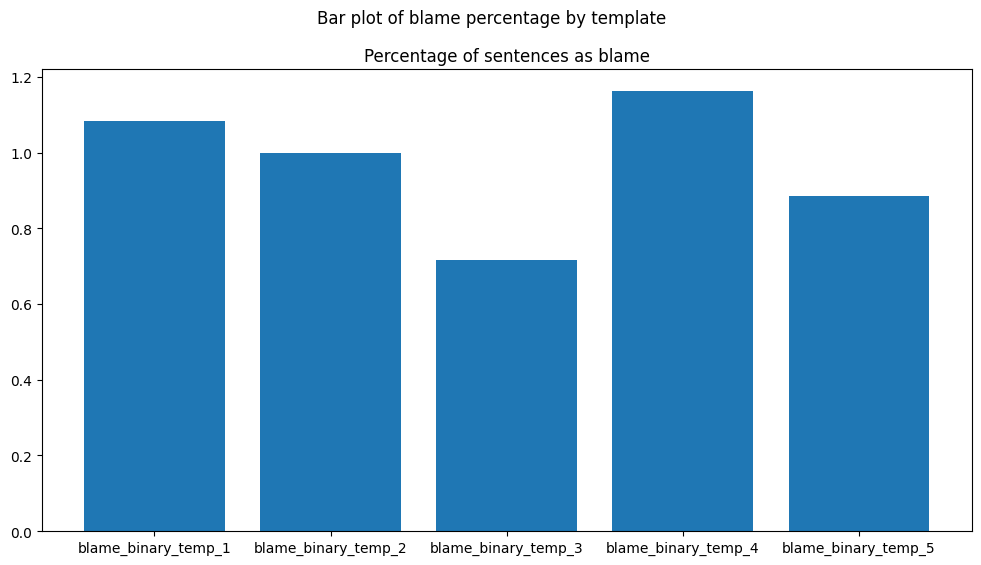

In [8]:
#Get percentage of blame for each template

plt.figure(figsize=(12, 6))

blame_percentage = []
abs_blame = []
template_name = []
for i in range(1,6):
    temp_name = f'blame_binary_temp_{i}'
    percentage_blame, total_sent, total_blame= total_blame_percentage(all_templates_data[temp_name])

    blame_percentage.append(percentage_blame)
    abs_blame.append(total_blame)
    template_name.append(temp_name)





plt.bar(template_name, blame_percentage)
plt.title('Percentage of sentences as blame')


plt.suptitle('Bar plot of blame percentage by template')

#for ax in axs.flat:
#    ax.set(xlabel='probability', ylabel='count')
plt.show()

In [ ]:
#Get data and do vizualization of the overlapping blame
# How much of the total blame by all templates do 4/3/2/1 templates agree upon
# Extract this information on a sentence level df['agreement_degree] maybe in format paragraph_i = [0,0,4,3,2,0,0,1]


In [9]:
blame_indices_template_1 = get_rows_and_positions(all_templates_data, col='blame_binary_temp_1')
blame_indices_template_2 = get_rows_and_positions(all_templates_data, col='blame_binary_temp_2')
blame_indices_template_3 = get_rows_and_positions(all_templates_data, col='blame_binary_temp_3')
blame_indices_template_4 = get_rows_and_positions(all_templates_data, col='blame_binary_temp_4')
blame_indices_template_5 = get_rows_and_positions(all_templates_data, col='blame_binary_temp_5')

In [ ]:
#list of dictioranries holding the paragraph/sentence indices for blame detected
dicts = [blame_indices_template_1, blame_indices_template_2, blame_indices_template_3, blame_indices_template_4, blame_indices_template_5]


# Step 1: make an empty dictionary to count appearances
# structure: {(paragraph, sentence): count}
counts = {}

# Step 2: loop through all dictionaries one by one
for d in dicts:
    # For each paragraph in the dictionary
    for paragraph, sentences in d.items():
        # For each sentence number in the paragraph
        for sentence in sentences:
            key = (paragraph, sentence)
            # If we’ve seen it before, increase count by 1
            if key in counts:
                counts[key] += 1
            # If not, add it and set count to 1
            else:
                counts[key] = 1

In [22]:
# Step 3: Count how many pairs appear in 1–5 dictionaries
summary = {i: 0 for i in range(1, 6)}
for count in counts.values():
    summary[count] += 1

print("Pairs appearing in N dictionaries:")
for n, total in summary.items():
    print(f"{n}: {total}")

Pairs appearing in N dictionaries:
1: 2015
2: 1007
3: 777
4: 803
5: 1955


In [38]:

# Step 4: Gather which pairs appear in each count
pairs_by_count = {i: [] for i in range(1, 6)}
for pair, count in counts.items():
    pairs_by_count[count].append(pair)

# Example: show all pairs that appear in exactly 3 dictionaries
print("\nPairs appearing in exactly 3 dictionaries:")
print(pairs_by_count[5])

# Step 5: Total number of unique (paragraph, sentence) pairs
n_unique_pairs = len(counts)
print(f"\nTotal unique (paragraph, sentence) pairs: {n_unique_pairs}")



Pairs appearing in exactly 3 dictionaries:
[(2, 235), (7, 3), (7, 4), (18, 0), (35, 0), (41, 3), (52, 1), (57, 82), (88, 0), (91, 4), (91, 5), (94, 6), (103, 6), (103, 61), (109, 5), (109, 8), (122, 2), (143, 9), (145, 64), (145, 71), (156, 2), (162, 4), (162, 111), (162, 122), (162, 124), (162, 130), (169, 4), (169, 6), (172, 2), (173, 17), (175, 23), (175, 26), (175, 53), (175, 62), (175, 71), (175, 79), (175, 97), (179, 42), (179, 64), (179, 72), (181, 14), (183, 97), (191, 8), (203, 0), (205, 8), (209, 6), (261, 11), (286, 4), (300, 14), (300, 16), (320, 7), (325, 12), (327, 11), (347, 10), (408, 1), (455, 2), (500, 4), (544, 1), (608, 19), (608, 98), (609, 1), (609, 7), (610, 3), (613, 0), (621, 15), (623, 8), (636, 2), (645, 41), (662, 45), (669, 18), (669, 30), (681, 28), (812, 0), (813, 14), (922, 1), (924, 2), (1002, 7), (1005, 4), (1039, 24), (1039, 26), (1043, 6), (1053, 3), (1065, 9), (1075, 12), (1083, 2), (1083, 7), (1083, 17), (1093, 10), (1093, 16), (1133, 10), (1139, 

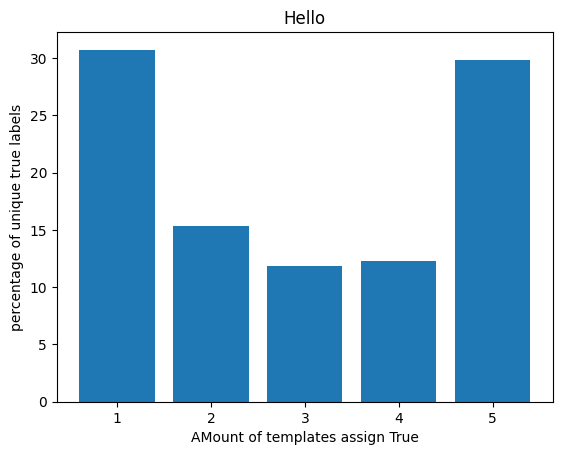

In [ ]:
percentages = []
for i in summary.values():
    percentages.append((float(i)/n_unique_pairs)*100)

amount_of_docts = summary.keys()

plt.figure()

plt.bar(amount_of_docts, percentages)

plt.title("Hello")
plt.xlabel("AMount of templates assign True")
plt.ylabel("percentage of unique true labels")

plt.show()

In [15]:
all_templates_data.to_csv("/work/MarkusLundsfrydJensen#1865/Bachelor_project/data_ready_for_analysis_10_10.csv", index = False)

In [16]:
import pandas as pd
all_templates_data = pd.read_csv("/work/MarkusLundsfrydJensen#1865/Bachelor_project/data_ready_for_analysis_10_10.csv")

In [17]:
all_templates_data.head()

,Unnamed: 0,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,...,blame_in_text,second_template_blame_in_text,third_template_blame_in_text,fourth_template_blame_in_text,fifth_template_blame_in_text,blame_binary_temp_1,blame_binary_temp_2,blame_binary_temp_3,blame_binary_temp_4,blame_binary_temp_5
0,0,1997-10-07,Dagsorden,1,Gert Petersen,NaN,NaN,True,191,Mødet er åbnet. I henhold til grundloven er Fo...,...,"[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,1997-10-07,Dagsorden,2,Formanden,NaN,NaN,True,182,"Jeg vil gerne takke Tinget for den tillid, man...",...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
2,2,1997-10-07,Statsministerens redegørelse i henhold til gru...,3,Poul Nyrup Rasmussen,S,379.0,False,18662,For 25 år siden sagde et flertal i befolkninge...,...,"[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,1997-10-09,1) Indstilling fra Udvalget til Valgs Prøvelse.,2,Formanden,NaN,NaN,True,47,Fra Udvalget til Valgs Prøvelse har jeg modtag...,...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
4,4,1997-10-09,2) Forhandling om redegørelse nr. R 1.,3,Torben Lund,S,379.0,False,2865,Vi står over for en meget afgørende folketings...,...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#Still trying to make the beneith working

In [ ]:
import pandas as pd

def extract_values_from_pairs(df, column_name, pairs):
    """
    Extracts values from a dataframe column containing lists,
    using (row_index, list_index) pairs.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe to extract from.
    column_name : str
        Name of the column containing lists.
    pairs : list of tuple
        Each tuple is (row_index, list_index).
        
    Returns
    -------
    dictiornary
        The extracted values (one per pair).
    """
    extracted_paras = {}
    
    for row_idx, list_idx in pairs:
        if row_idx not in extracted_paras:
            extracted_sents = {}
        # get the list from the specified cell
        values_list = df.at[row_idx, column_name]
        
        # get the specific element from that list
        extracted_sents{} = values_list[list_idx]
        
        extracted.append(value)
    
    return extracted_paras


In [ ]:
{2: {235: 'Regeringen vil også fortsætte sin offensive  miljøpolitik.'},

6557